# Processing Wine Dataset

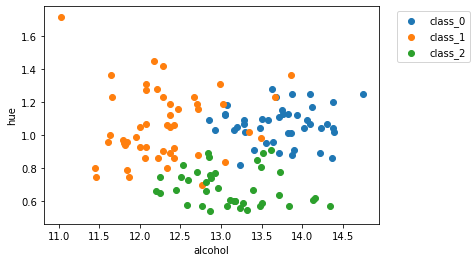

The test data to predict on (useful for comparing incorrect labels)


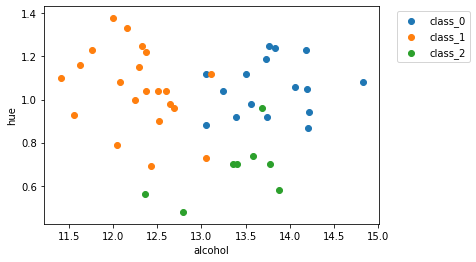

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

wine = load_wine()
X = np.hstack((wine.data[:, 0:1], wine.data[:, 10:11]))
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

wine_names=['class_0','class_1', 'class_2']
for i in range(0, 3):
    plt.scatter(X_train[y_train == i, 0],
                X_train[y_train == i, 1],
                marker='o',
                label=wine_names[i])

plt.xlabel('alcohol')
plt.ylabel('hue')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.show()

# Test data to predict on
for i in range(0, 3):
    plt.scatter(X_test[y_test == i, 0],
                X_test[y_test == i, 1],
                marker='o',
                label=wine_names[i])

plt.xlabel('alcohol')
plt.ylabel('hue')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

print("The test data to predict on (useful for comparing incorrect labels)")
plt.show()

# Linear SVM Dual

[[ 0 16  0]
 [ 0 21  0]
 [ 0  8  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.47      1.00      0.64        21
           2       0.00      0.00      0.00         8

    accuracy                           0.47        45
   macro avg       0.16      0.33      0.21        45
weighted avg       0.22      0.47      0.30        45



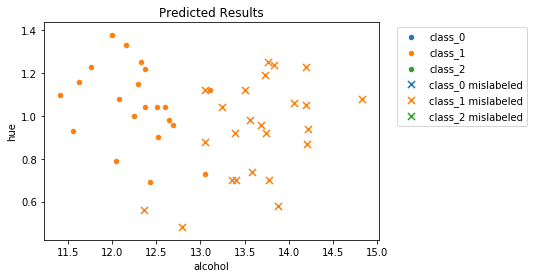

In [4]:
from cvxopt import matrix, solvers
from itertools import combinations 
solvers.options['show_progress'] = False
from sklearn import preprocessing

def kernel_svm(X, y): 
    m, n = X.shape
    xy = (X.T * y).T
    P = matrix(np.dot(xy, xy.T), tc='d')
    q = matrix(-np.ones((m,)), tc='d')
    G = matrix(-np.identity(m), tc='d')
    h = matrix(np.zeros(m), tc='d')
    A = matrix(np.array([y.T]), tc='d')
    b = matrix(np.zeros(1), tc='d')
    sol = solvers.qp(P,q,G,h,A,b)
    alphas = np.array(sol['x'])
    return alphas

def compute_classification_boundary (X, y, alpha):
    w = (np.dot((y * alpha.T), X)).T
    S = (alpha > 1e-4).flatten()
    b = np.dot(X[S], w)
    a = y[S].reshape(1, -1).T
    w0 = (a-b)[0][0]
    return w, w0

def K(xi, xj):
    return np.dot(xi,xj)

def f_dual(x, X, y, alphas, w, w0 = None):
    f = 0
    I = np.nonzero(np.around(alphas, 4))[0]
    for i in I:
        f += alphas[i]*y[i]*K(X[i].T, x)
    if w0 is not None:
        f += w0
    if f > 0:
        return 1
    return -1

def multiclass_SVM_Dual(X_train, y_train, X_test, y_test):
    y_labels = np.unique(y_train)
    y_pred = [[] for i in range(X_test.shape[0])]
    
    # separate data by class
    y_labels = np.unique(y_train)
    class_data = []
    for label in y_labels:
        class_data.append(X_train[tuple([y_train == label])])

    m, n = X_train.shape
    for label in y_labels:
        mm, nn = class_data[label].shape
        yy_train = np.hstack((np.full((mm), 1), np.full((m-mm), -1)))
        XX_train = class_data[label]
        for i in range(len(class_data)):
            if i != label:
                XX_train = np.vstack((XX_train, class_data[i]))
                
        alphas = kernel_svm(XX_train, yy_train)
        w, _ = compute_classification_boundary(XX_train, yy_train, alphas)
        
        yy_pred = np.full((X_test.shape[0], ), 0)
        for i in range(X_test.shape[0]):
            yy_pred[i] = f_dual(X_test[i], XX_train, yy_train, alphas, w)

        for i in range(yy_pred.shape[0]):
            if yy_pred[i] == 1:
                y_pred[i].append(label)
    
#     length = max(map(len, y_pred))
#     print(np.array([yi+[None]*(length-len(yi)) for yi in y_pred]))
    y_pred_final = np.full((y_test.shape[0]), 0)
    for i in range(0, y_test.shape[0]):
        if len(y_pred[i]) == 0:
            y_pred_final[i] = 0
        else:
            y_pred_final[i] = np.bincount(y_pred[i]).argmax()
    return y_pred_final
    
from sklearn.metrics import classification_report, confusion_matrix
y_pred = multiclass_SVM_Dual(X_train, y_train, X_test, y_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
    
    
### Plotting classification results
X_incorrect = []
y_incorrect = []
X_correct = []
y_correct = []
for i in range(X_test.shape[0]):
    if y_test[i] != y_pred[i]:
        X_incorrect.append(X_test[i])
        y_incorrect.append(y_pred[i])
    else:
        X_correct.append(X_test[i])
        y_correct.append(y_test[i])
X_incorrect = np.array(X_incorrect)
y_incorrect = np.array(y_incorrect)
X_correct = np.array(X_correct)
y_correct = np.array(y_correct)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
wine_names=['class_0', 'class_1', 'class_2']
for i in range(3):
    plt.scatter(X_correct[y_correct == i, 0],
                X_correct[y_correct == i, 1],
                s=20,
                marker='o',
                color = colors[i],
                label=wine_names[i])
    
mislabeled_names=['class_0 mislabeled', 'class_1 mislabeled', 'class_2 mislabeled']
for i in range(3):
    plt.scatter(X_incorrect[y_incorrect == i, 0],
                X_incorrect[y_incorrect == i, 1],
                s=50,
                marker='x',
                color = colors[i],
                label=mislabeled_names[i])

plt.xlabel('alcohol')
plt.ylabel('hue')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.title("Predicted Results")
plt.show()

# SVM Gaussian Kernel

[[16  0  0]
 [ 4 15  2]
 [ 2  0  6]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        16
           1       1.00      0.71      0.83        21
           2       0.75      0.75      0.75         8

    accuracy                           0.82        45
   macro avg       0.83      0.82      0.81        45
weighted avg       0.86      0.82      0.82        45



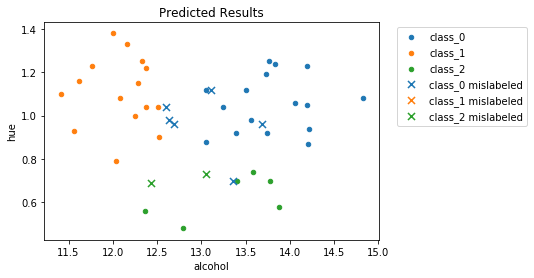

In [3]:
from cvxopt import matrix, solvers
from itertools import combinations 
solvers.options['show_progress'] = False

def rbf_kernel(gamma, x1, x2):
    distance = np.linalg.norm(x1 - x2) ** 2
    return np.exp(-gamma * distance)

def fit(X, y, gamma = None, C = None):
    m,n = X.shape

    # Set gamma to 1/n_features by default
    if gamma is None:
        gamma = 1 / n

    # Calculate kernel matrix
    kernel_matrix = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            kernel_matrix[i, j] = rbf_kernel(gamma, X[i], X[j])

    P = matrix(np.outer(y, y) * kernel_matrix, tc='d')
    q = matrix(np.ones(m) * -1)
    A = matrix(y, (1, m), tc='d')
    b = matrix(0, tc='d')

    if C is None:
        G = matrix(np.identity(m) * -1)
        h = matrix(np.zeros(m))
    else:
        G_max = np.identity(m) * -1
        G_min = np.identity(m)
        G = matrix(np.vstack((G_max, G_min)))
        h_max = matrix(np.zeros(m))
        h_min = matrix(np.ones(m) * self.C)
        h = matrix(np.vstack((h_max, h_min)))

    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    S = (alphas > 1e-4).flatten()
    lagr_multipliers = alphas[S]
    support_vectors = X[S]
    support_vector_labels = y[S]

    intercept = support_vector_labels[0]
    for i in range(len(lagr_multipliers)):
      intercept -= lagr_multipliers[i] * support_vector_labels[i] * rbf_kernel(gamma, support_vectors[i], support_vectors[0])
    
    return lagr_multipliers, support_vector_labels, support_vectors, intercept, gamma

def predict(X, lagr_multipliers, support_vector_labels, support_vectors, intercept, gamma):
    y_pred = []
    for sample in X:
        prediction = 0
        for i in range(len(lagr_multipliers)):
            prediction += lagr_multipliers[i] * support_vector_labels[i] * rbf_kernel(gamma, support_vectors[i], sample)
        prediction += intercept
        y_pred.append(np.sign(prediction))
    return np.array(y_pred)


def multiclass_SVM_Gaussian(X_train, y_train, X_test, y_test):
    y_labels = np.unique(y_train)
    y_pred = [[] for i in range(X_test.shape[0])]
    
    # separate data by class
    y_labels = np.unique(y_train)
    class_data = []
    for label in y_labels:
        class_data.append(X_train[tuple([y_train == label])])

    m, n = X_train.shape
    for label in y_labels:
        mm, nn = class_data[label].shape
        yy_train = np.hstack((np.full((mm), 1), np.full((m-mm), -1)))
        XX_train = class_data[label]
        for i in range(len(class_data)):
            if i != label:
                XX_train = np.vstack((XX_train, class_data[i]))
           
        lagr_multipliers, support_vector_labels, support_vectors, intercept, gamma = fit(XX_train, yy_train)
        yy_pred = predict(X_test, lagr_multipliers, support_vector_labels, support_vectors, intercept, gamma)

        for i in range(yy_pred.shape[0]):
            if yy_pred[i] == 1:
                y_pred[i].append(label)
    
#     length = max(map(len, y_pred))
#     print(np.array([yi+[None]*(length-len(yi)) for yi in y_pred]))
    y_pred_final = np.full((y_test.shape[0]), 0)
    for i in range(0, y_test.shape[0]):
        if len(y_pred[i]) == 0:
            y_pred_final[i] = 0
        else:
            y_pred_final[i] = np.bincount(y_pred[i]).argmax()
    return y_pred_final
    
    
from sklearn.metrics import classification_report, confusion_matrix
y_pred = multiclass_SVM_Gaussian(X_train, y_train, X_test, y_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
    
### Plotting classification results
X_incorrect = []
y_incorrect = []
X_correct = []
y_correct = []
for i in range(X_test.shape[0]):
    if y_test[i] != y_pred[i]:
        X_incorrect.append(X_test[i])
        y_incorrect.append(y_pred[i])
    else:
        X_correct.append(X_test[i])
        y_correct.append(y_test[i])
X_incorrect = np.array(X_incorrect)
y_incorrect = np.array(y_incorrect)
X_correct = np.array(X_correct)
y_correct = np.array(y_correct)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
wine_names=['class_0', 'class_1', 'class_2']
for i in range(3):
    plt.scatter(X_correct[y_correct == i, 0],
                X_correct[y_correct == i, 1],
                s=20,
                marker='o',
                color = colors[i],
                label=wine_names[i])
    
mislabeled_names=['class_0 mislabeled', 'class_1 mislabeled', 'class_2 mislabeled']
for i in range(3):
    plt.scatter(X_incorrect[y_incorrect == i, 0],
                X_incorrect[y_incorrect == i, 1],
                s=50,
                marker='x',
                color = colors[i],
                label=mislabeled_names[i])

plt.xlabel('alcohol')
plt.ylabel('hue')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.title("Predicted Results")
plt.show()